# Import Library

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from torchsummary import summary

# Data Preprocessing

In [127]:
path = './digit-recognizer/'
test_data = pd.read_csv(path+'test.csv')
train_data = pd.read_csv(path+'train.csv')
# Ground Truth of training data
groundtruth = np.array(train_data['label'])
train_data = train_data.drop(['label'], axis=1)

In [128]:
# Transfer dataframe to np array
train_set = np.array(train_data)
test_set = np.array(test_data)
# Reshape of np array to matrix form [1*28*28] for each black-white image
train_set = np.reshape(train_set, [train_set.shape[0], 1, 28, 28])
test_set = np.reshape(test_set, [test_set.shape[0], 1, 28, 28])
print(train_set.shape)
print(test_set.shape)
# Data Normalization
nor_train = np.linalg.norm(train_set)
train_set = train_set / nor_train
nor_test = np.linalg.norm(test_set)
test_set = test_set / nor_test
# Split training data into train_set and val_set 4:1 using 5-Fold Cross Validation
k = 5
epoch = 50
batch_size = 64
splits = KFold(n_splits=k, shuffle=True, random_state=26)

(42000, 1, 28, 28)
(28000, 1, 28, 28)


In [129]:
# Building my own dataset
class digitDataset(Dataset):
    def __init__(self, x, y=None):
        self.data = torch.from_numpy(x).float()
        if y is not None:
            y = y.astype(int)
            self.label = torch.LongTensor(y)
        else: self.label = None
    def __getitem__(self, index):
        if self.label is not None:
            return self.data[index], self.label[index]
        else: return self.data[index]
    def __len__(self):
        return len(self.data)

# CNN Model Architecture

In [130]:
# Loss Function
criterion = nn.CrossEntropyLoss()
# Checking using device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Dictionary for saving each fold's train and val loss
foldperf = {}

In [131]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.CNN_layer = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 128, 2, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.FC_layer = nn.Sequential(
            nn.Linear(2048, 10),
            # nn.Softmax()
        )
    def forward(self, x):
        x = self.CNN_layer(x)
        x = self.FC_layer(x)
        return x

In [132]:
test_model = CNNModel()
summary(test_model, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
         LeakyReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          36,928
       BatchNorm2d-5           [-1, 64, 28, 28]             128
         LeakyReLU-6           [-1, 64, 28, 28]               0
           Dropout-7           [-1, 64, 28, 28]               0
         MaxPool2d-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         147,712
      BatchNorm2d-10          [-1, 256, 14, 14]             512
        LeakyReLU-11          [-1, 256, 14, 14]               0
           Conv2d-12          [-1, 256, 14, 14]         590,080
      BatchNorm2d-13          [-1, 256, 14, 14]             512
        LeakyReLU-14          [-1, 256,

# K Fold Cross Validation

In [133]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
    return train_loss, train_correct

In [134]:
def valid_epoch(model, device, dataloader, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = loss_fn(output, labels)
        valid_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        val_correct += (predictions == labels).sum().item()
    return valid_loss, val_correct

In [135]:
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(train_set.shape[0]))):
    print('Fold {}'.format(fold + 1))
    train_dset = digitDataset(train_set, groundtruth)
    train_loader = DataLoader(train_dset, batch_size=batch_size, sampler=train_idx)
    val_loader = DataLoader(train_dset, batch_size=batch_size, sampler=val_idx)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model =CNNModel()
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-5)
    
    history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}

    for Epoch in range(epoch):
        train_loss, train_correct = train_epoch(model, device, train_loader, criterion, optimizer)
        val_loss, val_correct = valid_epoch(model, device, val_loader, criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        val_loss = val_loss / len(val_loader.sampler)
        val_acc = val_correct / len(val_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Validae Loss:{:.3f} AVG Training Acc {:.2f} % AVG Validate Acc {:.2f} %".format(Epoch + 1,
                                                                                                             epoch,
                                                                                                             train_loss,
                                                                                                             val_loss,
                                                                                                             train_acc,
                                                                                                             val_acc))
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,'k_cross_CNN.pt')

Fold 1
Epoch:1/50 AVG Training Loss:0.574 AVG Validae Loss:0.625 AVG Training Acc 86.55 % AVG Validate Acc 94.17 %
Epoch:2/50 AVG Training Loss:0.159 AVG Validae Loss:0.403 AVG Training Acc 96.51 % AVG Validate Acc 96.77 %
Epoch:3/50 AVG Training Loss:0.102 AVG Validae Loss:0.327 AVG Training Acc 97.57 % AVG Validate Acc 97.57 %
Epoch:4/50 AVG Training Loss:0.075 AVG Validae Loss:0.251 AVG Training Acc 98.31 % AVG Validate Acc 98.12 %
Epoch:5/50 AVG Training Loss:0.061 AVG Validae Loss:0.209 AVG Training Acc 98.54 % AVG Validate Acc 98.55 %
Epoch:6/50 AVG Training Loss:0.050 AVG Validae Loss:0.192 AVG Training Acc 98.77 % AVG Validate Acc 98.45 %
Epoch:7/50 AVG Training Loss:0.043 AVG Validae Loss:0.163 AVG Training Acc 98.95 % AVG Validate Acc 98.75 %
Epoch:8/50 AVG Training Loss:0.038 AVG Validae Loss:0.148 AVG Training Acc 99.07 % AVG Validate Acc 98.83 %
Epoch:9/50 AVG Training Loss:0.033 AVG Validae Loss:0.131 AVG Training Acc 99.22 % AVG Validate Acc 98.93 %
Epoch:10/50 AVG Train

In [136]:
vall_f,tl_f,vala_f,ta_f=[],[],[],[]
k=5
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     vall_f.append(np.mean(foldperf['fold{}'.format(f)]['val_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     vala_f.append(np.mean(foldperf['fold{}'.format(f)]['val_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Val Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Val Acc: {:.2f}".format(np.mean(tl_f),np.mean(vall_f),np.mean(ta_f),np.mean(vala_f)))

Performance of 5 fold cross validation
Average Training Loss: 0.029 	 Average Val Loss: 0.098 	 Average Training Acc: 99.35 	 Average Val Acc: 98.83


In [137]:
diz_ep = {'train_loss_ep':[],'val_loss_ep':[],'train_acc_ep':[],'val_acc_ep':[]}

for i in range(epoch):
      diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_loss'][i] for f in range(k)]))
      diz_ep['val_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['val_loss'][i] for f in range(k)]))
      diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_acc'][i] for f in range(k)]))
      diz_ep['val_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['val_acc'][i] for f in range(k)]))

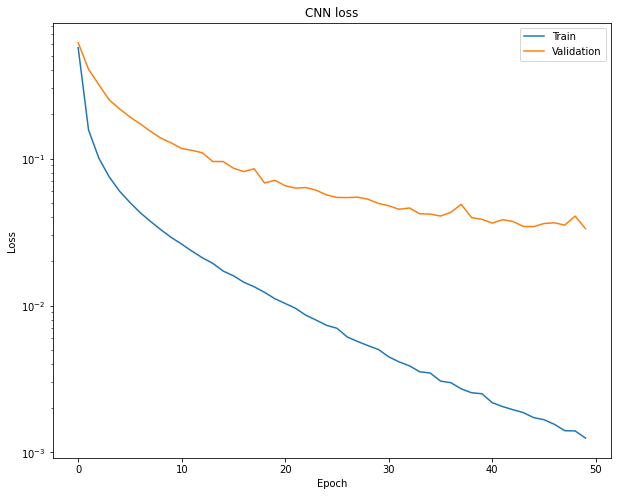

In [138]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['val_loss_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
plt.title('CNN loss')
plt.show()

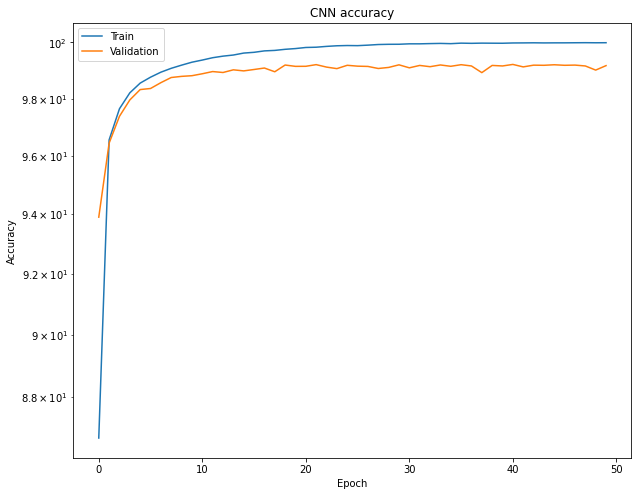

In [139]:
# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['val_acc_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.grid()
plt.legend()
plt.title('CNN accuracy')
plt.show()

In [140]:
model = torch.load('./k_cross_CNN.pt')
model.eval()    

CNNModel(
  (CNN_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.3, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Dropou

In [141]:
result_list = []
with torch.no_grad():
    model.eval()
    test_loader = digitDataset(test_set)
    test_loader = DataLoader(test_loader, batch_size= batch_size, shuffle= False)
    for batch_idx, batch in enumerate(test_loader):
        images = batch
        result_list.append(model(images.to(device)))

In [142]:
test_result = np.zeros((len(test_set), 1), dtype=np.int64)
for i, m in enumerate(result_list):
    for j, row in enumerate(m):
        r = torch.argmax(row).item()
        test_result[i*batch_size + j] =  r

In [143]:
prediction = pd.read_csv(path + 'sample_submission.csv')
prediction['Label'] = test_result
# output prediction result
prediction.to_csv('pre.csv', index= False)